In [1]:
import os
import sys
from collections import defaultdict
from functools import partial
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.errors import SettingWithCopyWarning
import numpy as np
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

from tqdm.notebook import tqdm 
from math import factorial, log, log10, log1p, floor, ceil
from scipy.stats import chi2

import multiprocess

sns.set()
sns.set_style("ticks")

import tskit
import msprime

import geneinfo as gi
gi.email('kaspermunch@birc.au.dk')

# scale down size of default plots
sns.set_context("paper")
import matplotlib as mpl
scale = 0.8
d = dict([(k, v*scale) for (k, v) in sns.plotting_context('paper').items()])
d['figure.figsize'] = [5.4, 3.5]
mpl.rcParams.update(d)

def modpath(p, parent=None, base=None, suffix=None):
    par, name = os.path.split(p)
    name_no_suffix, suf = os.path.splitext(name)
    if type(suffix) is str:
        suf = suffix
    if parent is not None:
        par = parent
    if base is not None:
        name_no_suffix = base
    new_path = os.path.join(par, name_no_suffix + suf)
    if type(suffix) is tuple:
        assert len(suffix) == 2
        new_path, nsubs = re.subn(r'{}$'.format(suffix[0]), suffix[1], new_path)
        assert nsubs == 1, nsubs
    return new_path

In [2]:
from scipy.stats import chi2
def fisher_method(pvalues):
    df = 2* len(pvalues)
    return 1-chi2.cdf(-2*sum(map(log, pvalues)), df)
    
p = fisher_method([1e-4, 1e-3])
-np.log10(p)

5.766544551240487

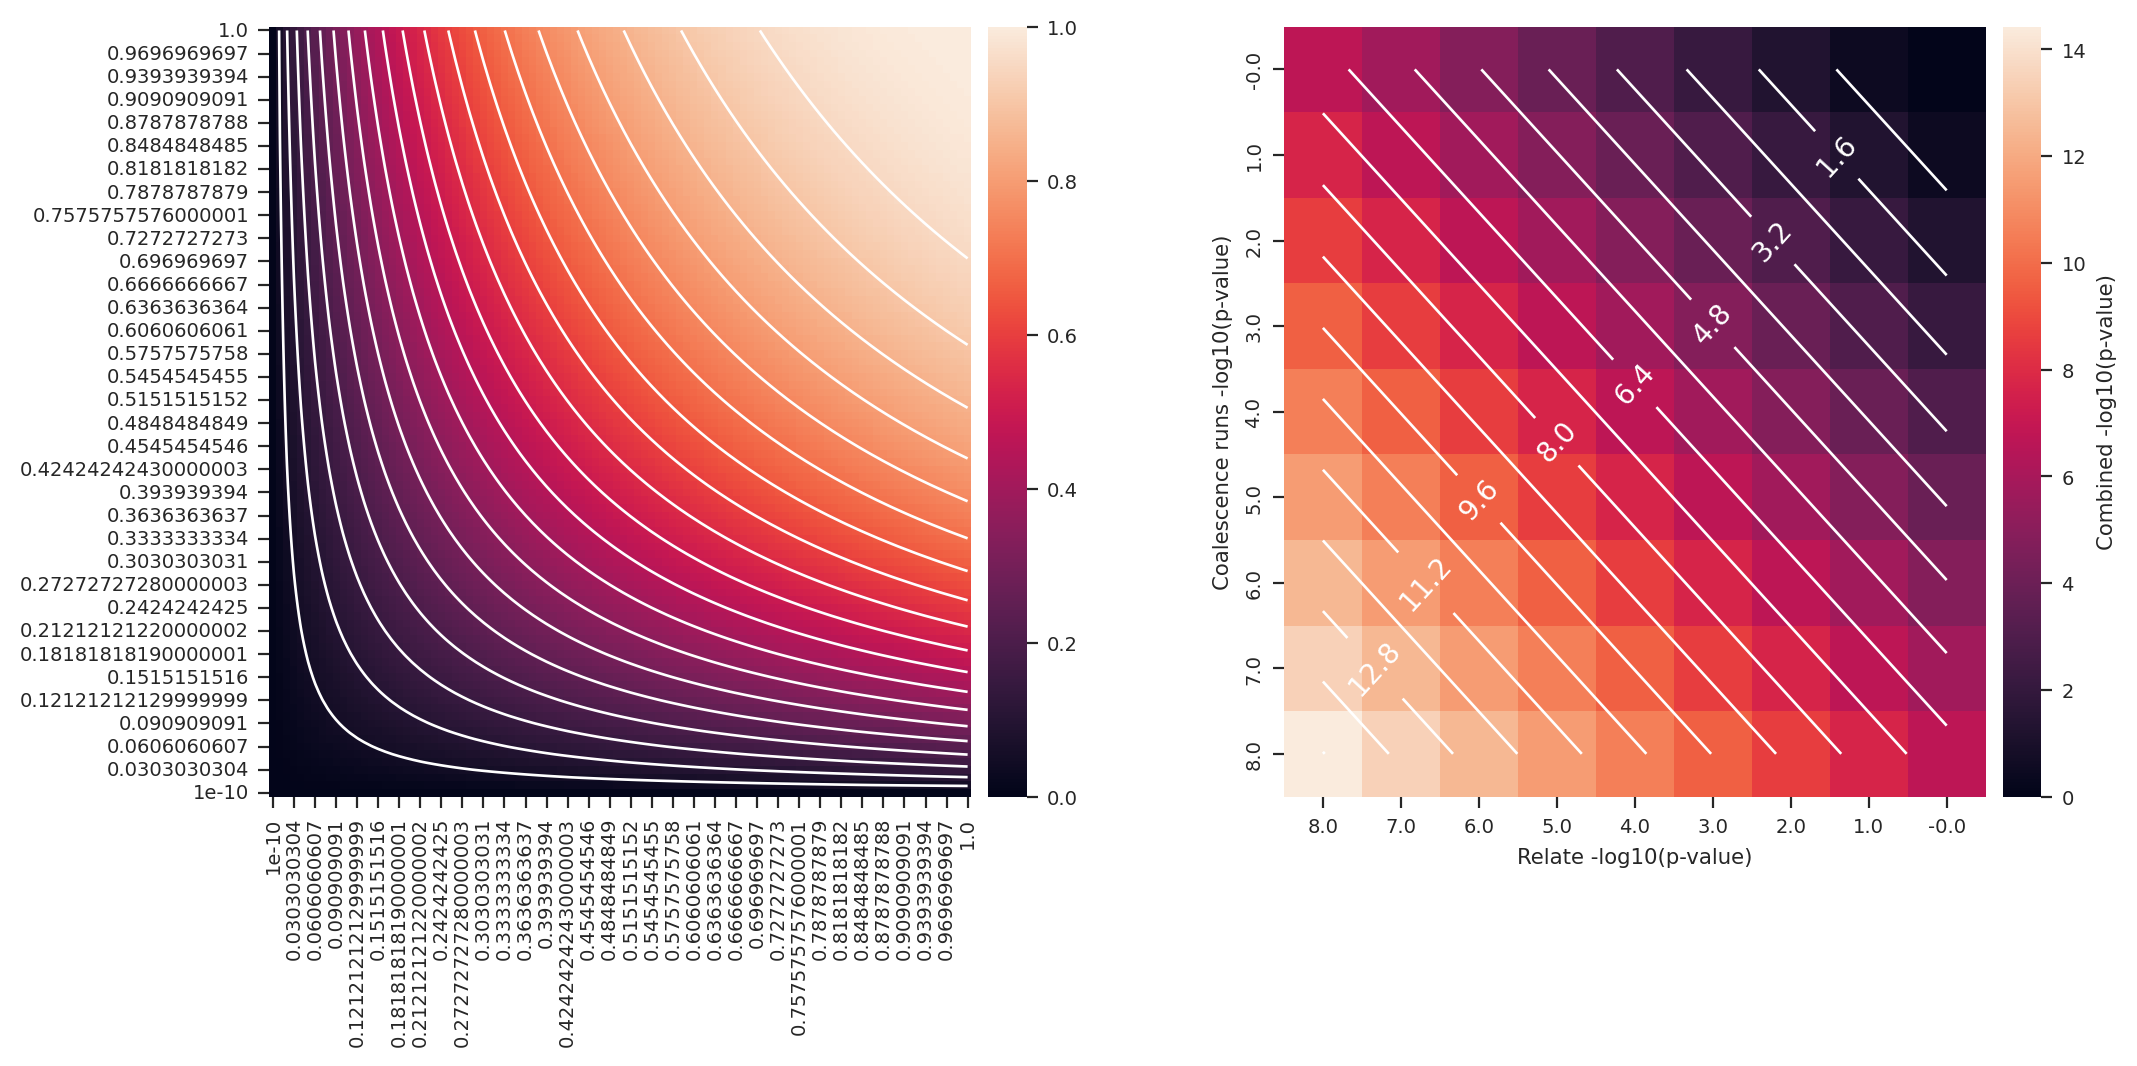

In [3]:
def fisher_method(pvalues):
    df = 2* len(pvalues)
    return 1-chi2.cdf(-2*sum(map(log, pvalues)), df)
    
n = 100
x = np.linspace(1e-10, 1, n)
a = np.array(list(itertools.product(x, x)))
b = np.apply_along_axis(fisher_method, 1, a)
c = b.reshape(n, n)
data = pd.DataFrame(c)
data.index = x
data.columns = x

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(data=data, cbar_kws={'pad': 0.02}, ax=ax1)
ax1.contour(np.arange(.5, data.shape[1]), np.arange(.5, data.shape[0]), data, levels=20, colors='white')
ax1.invert_yaxis()



def fisher_method_log10(pvalues):
    df = 2* len(pvalues)
    return -np.log10(1-chi2.cdf(-2*sum(map(log, pvalues)), df))
    # return 1-chi2.cdf(-2*sum(map(log, pvalues)), df)

pmin = -8
n = -pmin*1+1
# x = np.logspace(1e-10, 1, n)
x = np.logspace(-8, 0, n)
a = np.array(list(itertools.product(x, x)))
b = np.apply_along_axis(fisher_method_log10, 1, a)
c = b.reshape(n, n)
data = pd.DataFrame(c)
data.index = np.round(-np.log10(x), 1)
data.columns = np.round(-np.log10(x), 1)

sns.heatmap(data=data, cbar_kws={'pad': 0.02, 'label': 'Combined -log10(p-value)'}, ax=ax2)
cs = ax2.contour(np.arange(.5, data.shape[1]), np.arange(.5, data.shape[0]), data, levels=20, colors='white')

def fmt(x):
    return np.round(x,2)

ax2.clabel(cs, cs.levels[::2], inline=True, fmt=fmt, fontsize=10)
ax2.invert_yaxis()
plt.xlabel('Relate -log10(p-value)')
plt.ylabel('Coalescence runs -log10(p-value)') ;

In [4]:
import scipy

class Comb():

    cache = {}
    
    def __init__(self):
        pass

    def __call__(self, n, k, exact=True):
        if (n, k) not in self.cache:
            self.cache[(n, k)] = scipy.special.comb(n, k, exact=exact)
        return self.cache[(n, k)]

    @classmethod
    def clear(cls):
        cls.cache = {}

    def __enter__(self):

        def init_worker(data):
            # declare scope of a new global variable
            global comb
            # store argument in the global variable for this process
            comb = data
            
        self.pool = multiprocess.Pool(processes=8, initializer=init_worker, initargs=(self,))
        return self.pool

    def __exit__(self, type, value, tb):
        self.pool.close()

Comb().clear()
comb = Comb()

with Comb() as pool:
    pass

In [5]:
## Combinatorial results and functions for run probabilities ##
def get_coalescence_runs(all_times, clade_times):
    clade_times_set = set(clade_times)
    k, fn = 1, 1
    coalescence_runs = []
    first_derived_coal_found = False
    for t in all_times:
        is_derived = int( t in clade_times_set)
        if first_derived_coal_found:
            coalescence_runs.append(is_derived)
        if is_derived:
            # get all the coalescences *after* the first derived one. So that the first can be both 0 and 1
            first_derived_coal_found = True
    return np.array(coalescence_runs)

def get_runs_of_1s(bits):
    for bit, group in itertools.groupby(bits):
        if bit:
            yield sum(group)

def get_all_runs(bits):
    for bit, group in itertools.groupby(bits):
        if bit:
            yield sum(group)
    bits = np.absolute(bits - 1)
    for bit, group in itertools.groupby(bits):
        if bit:
            yield sum(group)

In [6]:
def prob_nr_of_runs(n, n1, n2):
    """
    Probability of the number runs of either zeros or ones
    n: number of runs
    n0: nr zeros
    n1: nr ones
    """
    if n % 2:
        # uneven
        k = (n - 1) //  2
        return (comb(n1-1, k)*comb(n2-1, k-1) + comb(n1-1, k-1)*comb(n2-1, k)) / comb(n1+n2, n1)
    else:
        # even
        k = n // 2
        return 2*comb(n1-1, k-1)*comb(n2-1, k-1) / comb(n1+n2, n1)    

In [10]:
## Compute cached probabilities ##


import multiprocess
pool = multiprocess.Pool(processes=8)

n = 200
dim = 2*n+1
cache = np.ndarray(shape=(n+1, n+1, 2*n+1), dtype=float)
cache[:, :, :] = np.nan
for n0 in tqdm(range(1, n+1)):
    for n1 in range(1, n+1):
        for r in range(1, n0+n1):
            cache[n0, n1, r] = prob_nr_of_runs(r, n0, n1)

pool.close()

np.save('prob_nr_of_runs_cache.npy', cache)

  0%|          | 0/200 [00:00<?, ?it/s]

In [12]:
## Compute p-values for data ##
prob_nr_of_runs_cache = np.load('prob_nr_of_runs_cache.npy')

def extract_population_name(file_path):
    # Split the file path by '/'
    parts = file_path.split('/')
    # Extract the second to last part which contains the population name
    return parts[-4]

for treeseq_file_name in [
    # africans
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/LWK/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/GWD/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/ESN/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/MSL/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/YRI/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    # europeans
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/GBR/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/FIN/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/IBS/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/TSI/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/PUR/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    #asians
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/CDX/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/CHB/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/CHS/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/JPT/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/KHV/relate/run_relate/1000g_ppl_phased_haplotypes.trees'
                         ]:
    print(os.path.basename(treeseq_file_name))
    
    population_name = extract_population_name(treeseq_file_name)
    
    output_file_name = modpath(treeseq_file_name, parent='/home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/', suffix=f'_{population_name}_runstats.h5')
    
    tree_seq = tskit.load(treeseq_file_name)
    
    
    nr_samples = tree_seq.num_samples
    
    records = []
    nodes_time = tree_seq.nodes_time

    tree_idx = 0
    for tree in tqdm(tree_seq.trees()):
    
        N = tree.num_samples()
        all_times = [nodes_time[n] for n in tree.timedesc() if not tree.is_leaf(n)]
        for mut in tree.mutations():
            node = tree_seq.mutations_node[mut.id]
            clade_times = [nodes_time[n] for n in tree.timedesc(node) if not tree.is_leaf(n)]

            # nr-all-runs and max ones-run probabilities
            runs = get_coalescence_runs(all_times, clade_times)

            if len(runs) < nr_samples / 4:
                continue
            
            n1 = sum(runs)
            n0 = len(runs) - n1
            run_lengths = np.fromiter(get_all_runs(runs), int)
            runs_of_1s = list(get_runs_of_1s(runs))

            if len(runs_of_1s) == 0:
                # trippleton or smaller
                continue

            max_ones_run_len = max(runs_of_1s)
            nr_runs = run_lengths.size

            
            if nr_runs == 1 or len(runs) <= 2 or nr_runs == len(runs):
                pvalue_nr_runs = np.nan
            else:
                try:
                    pvalue_nr_runs = prob_nr_of_runs_cache[n0, n1, 1:(nr_runs+1)].sum()
                except IndexError:
                    pvalue_nr_runs = sum(prob_nr_of_runs(x, n0, n1) for x in range(1, nr_runs+1))
            
            interval = tree.interval
            num_mutations = tree.num_mutations

            clade_left, clade_right = interval.left, interval.right

            assert clade_times
            
            records.append(['nr_runs',
                            mut.site, 
                            pvalue_nr_runs,
                            nr_runs,
                            len(runs),                            
                            clade_times[0], 
                            0,
                            interval.left,
                            interval.right,
                            clade_left, 
                            clade_right,
                            num_mutations])
    
    
        tree_idx += 1
    
    
    df = pd.DataFrame.from_records(records, columns=['stat_name', 'site', 'p', 'stat', 'nr_coal', 't1', 't2', 
                                                     'tree_left', 'tree_right', 'clade_left', 'clade_right', 
                                                     'nr_mut'])
    df['pos'] = tree_seq.sites_position[df.site]
    df.to_hdf(output_file_name, 'df', format='table')

1000g_ppl_phased_haplotypes.trees


  0%|          | 0/41582 [00:00<?, ?it/s]

1000g_ppl_phased_haplotypes.trees


  0%|          | 0/40565 [00:00<?, ?it/s]

1000g_ppl_phased_haplotypes.trees


  0%|          | 0/39218 [00:00<?, ?it/s]

1000g_ppl_phased_haplotypes.trees


  0%|          | 0/38940 [00:00<?, ?it/s]

1000g_ppl_phased_haplotypes.trees


  0%|          | 0/40779 [00:00<?, ?it/s]

1000g_ppl_phased_haplotypes.trees


  0%|          | 0/15057 [00:00<?, ?it/s]

1000g_ppl_phased_haplotypes.trees


  0%|          | 0/16468 [00:00<?, ?it/s]

1000g_ppl_phased_haplotypes.trees


  0%|          | 0/19520 [00:00<?, ?it/s]

1000g_ppl_phased_haplotypes.trees


  0%|          | 0/18072 [00:00<?, ?it/s]

1000g_ppl_phased_haplotypes.trees


  0%|          | 0/27999 [00:00<?, ?it/s]

1000g_ppl_phased_haplotypes.trees


  0%|          | 0/14479 [00:00<?, ?it/s]

1000g_ppl_phased_haplotypes.trees


  0%|          | 0/14789 [00:00<?, ?it/s]

1000g_ppl_phased_haplotypes.trees


  0%|          | 0/15894 [00:00<?, ?it/s]

1000g_ppl_phased_haplotypes.trees


  0%|          | 0/13959 [00:00<?, ?it/s]

1000g_ppl_phased_haplotypes.trees


  0%|          | 0/15780 [00:00<?, ?it/s]

In [5]:
# List of .h5 file paths
h5_file_paths = [
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/1000g_ppl_phased_haplotypes_LWK_runstats.h5',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/1000g_ppl_phased_haplotypes_GWD_runstats.h5',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/1000g_ppl_phased_haplotypes_ESN_runstats.h5',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/1000g_ppl_phased_haplotypes_MSL_runstats.h5',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/1000g_ppl_phased_haplotypes_YRI_runstats.h5',
    #'/home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/1000g_ppl_phased_haplotypes_GBR_runstats.h5',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/1000g_ppl_phased_haplotypes_FIN_runstats.h5',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/1000g_ppl_phased_haplotypes_TSI_runstats.h5',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/1000g_ppl_phased_haplotypes_IBS_runstats.h5',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/1000g_ppl_phased_haplotypes_PUR_runstats.h5',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/1000g_ppl_phased_haplotypes_CDX_runstats.h5',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/1000g_ppl_phased_haplotypes_CHB_runstats.h5',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/1000g_ppl_phased_haplotypes_CHS_runstats.h5',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/1000g_ppl_phased_haplotypes_JPT_runstats.h5',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/1000g_ppl_phased_haplotypes_KHV_runstats.h5'
]

# Directory to save the CSV files
csv_dir_path = '/home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/'

# Function to convert .h5 to .csv
def convert_h5_to_csv(h5_file_path, csv_dir_path):
    # Read the .h5 file
    df = pd.read_hdf(h5_file_path)

    # Create the output CSV file path
    csv_file_name = os.path.splitext(os.path.basename(h5_file_path))[0] + '.csv'
    csv_file_path = os.path.join(csv_dir_path, csv_file_name)

    # Save the DataFrame to a CSV file
    df.to_csv(csv_file_path, index=False)
    print(f"Converted {h5_file_path} to {csv_file_path}")

# Loop through each .h5 file and convert it to CSV
for h5_file_path in h5_file_paths:
    convert_h5_to_csv(h5_file_path, csv_dir_path)



Converted /home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/1000g_ppl_phased_haplotypes_LWK_runstats.h5 to /home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/1000g_ppl_phased_haplotypes_LWK_runstats.csv
Converted /home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/1000g_ppl_phased_haplotypes_GWD_runstats.h5 to /home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/1000g_ppl_phased_haplotypes_GWD_runstats.csv
Converted /home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/1000g_ppl_phased_haplotypes_ESN_runstats.h5 to /home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/1000g_ppl_phased_haplotypes_ESN_runstats.csv
Converted /home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/1000g_ppl_phased_haplotypes_MSL_runstats.h5 to /home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/1000g_ppl_phased_haplotypes_MSL_runstats.csv
Converted /home/ari/ari-intern/people/ari/ariadna-intern/steps/runs_test/1000g_ppl_phase

In [ ]:
# africans
LWK = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_LWK_runstats.h5')
GWD = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_GWD_runstats.h5')
ESN = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_ESN_runstats.h5')
MSL = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_MSL_runstats.h5')
YRI = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_YRI_runstats.h5')

# europeans
GBR = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_GBR_runstats.h5')
FIN = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_FIN_runstats.h5')
IBS = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_IBS_runstats.h5')
TSI = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_TSI_runstats.h5')


# asians 
CDX = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_CDX_runstats.h5')
CHB = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_CHB_runstats.h5')
CHS = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_CHS_runstats.h5')
JPT = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_JPT_runstats.h5')
KHV = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_KHV_runstats.h5')

In [16]:
LWK = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_LWK_runstats.h5')
print(LWK)

       stat_name    site         p  stat  nr_coal            t1  t2  \
0        nr_runs       3  1.000000     3      101    449.973511   0   
1        nr_runs       4  1.000000    21      121    992.319519   0   
2        nr_runs       5  0.959909    80      146   5125.490723   0   
3        nr_runs      11  0.797558    74      151  16823.707031   0   
4        nr_runs      18  1.000000     3       41    135.369598   0   
...          ...     ...       ...   ...      ...           ...  ..   
317382   nr_runs  479277  0.728110    25      133   1796.468018   0   
317383   nr_runs  479278  1.000000     7      103    511.939178   0   
317384   nr_runs  479279  1.000000    33      142   3474.286865   0   
317385   nr_runs  479283  1.000000     3       67    162.246826   0   
317386   nr_runs  479284  0.764533    76      149   8431.162109   0   

          tree_left   tree_right   clade_left  clade_right  nr_mut  \
0         2781609.5    2781896.0    2781609.5    2781896.0       2   
1      

In [ ]:
LWK_R = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/steps/LWK/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele')
print(LWK_R)

In [18]:
GWD = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_GWD_runstats.h5')
print(GWD)

       stat_name    site         p  stat  nr_coal           t1  t2  \
0        nr_runs       0  0.911416    73      250  2984.859131   0   
1        nr_runs       1  0.800576    59      249  2888.384033   0   
2        nr_runs       2  0.813803   103      237  1255.903076   0   
3        nr_runs       3  1.000000     9      182   307.347534   0   
4        nr_runs       4  0.877995    41      221   701.226501   0   
...          ...     ...       ...   ...      ...          ...  ..   
356782   nr_runs  492096  1.000000    11      237  1264.091919   0   
356783   nr_runs  492098  0.810575    59      245  1747.613770   0   
356784   nr_runs  492099  0.504290    37      233  1128.960449   0   
356785   nr_runs  492100  1.000000     3      119   121.500587   0   
356786   nr_runs  492101  0.991798   144      257  6472.866211   0   

          tree_left   tree_right   clade_left  clade_right  nr_mut  \
0               0.0    2781549.0          0.0    2781549.0       1   
1         2781549.0

In [ ]:
## MANHATTAN PLOTS ##

/scratch/38442760/ipykernel_3651814/2944297291.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_LWK['-log10p'] = -np.log10(plot_LWK.p)


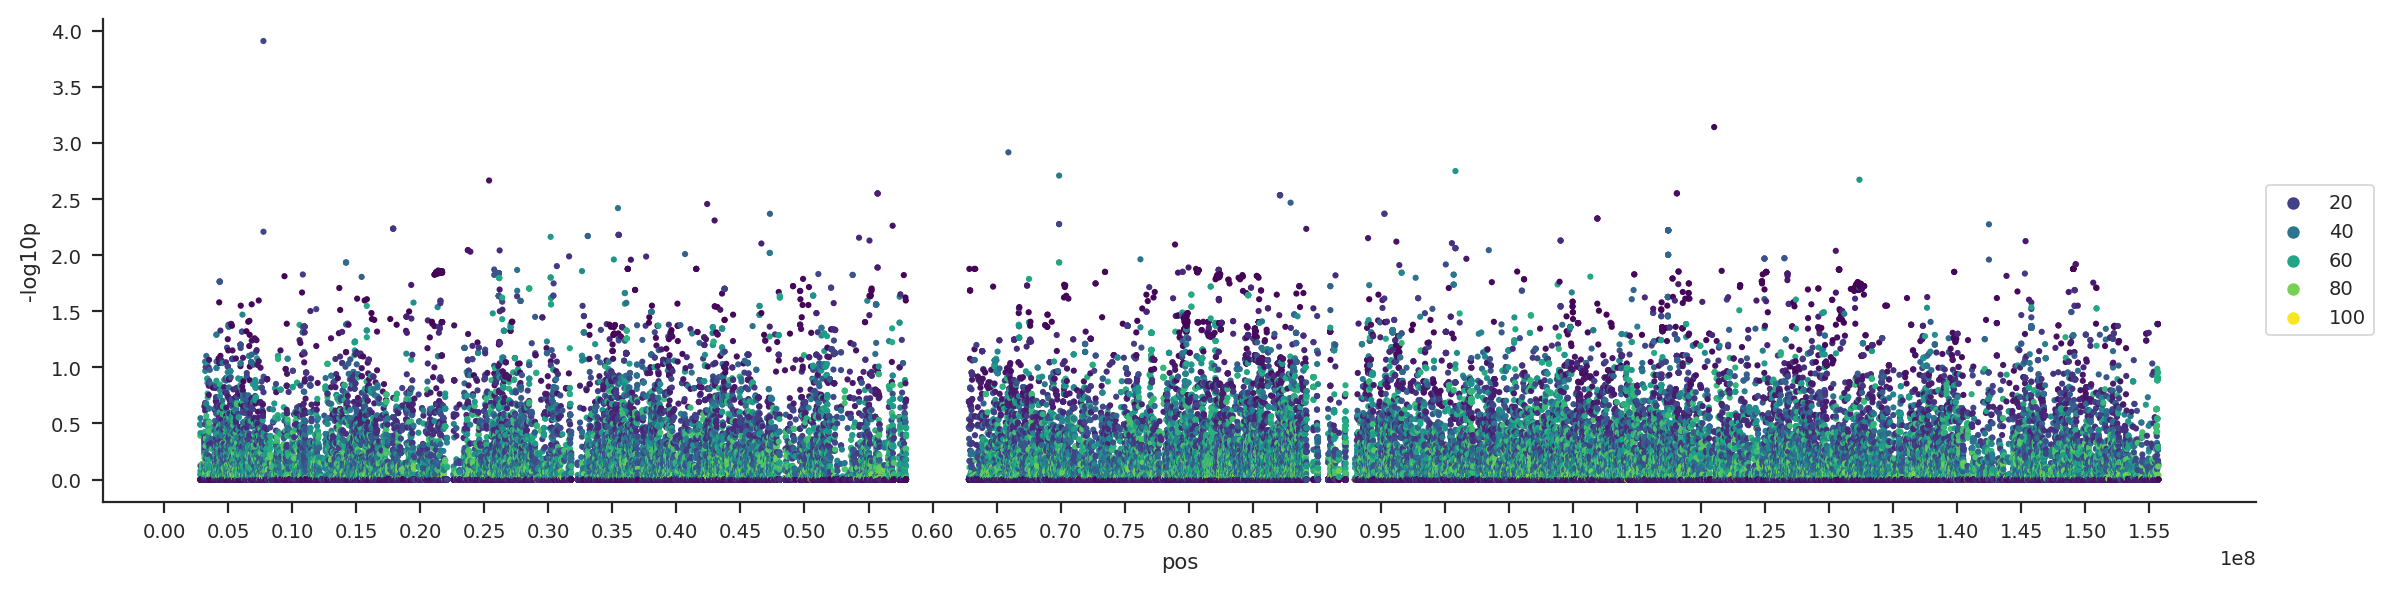

In [19]:
# LWK
plot_LWK = LWK.loc[(LWK.stat_name == 'nr_runs') & (LWK.nr_mut > 20)]
plot_LWK['-log10p'] = -np.log10(plot_LWK.p)
np.log10(plot_LWK.index.size)

import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    fig, ax = plt.subplots(1, 1, figsize=(12,3))
    sns.scatterplot(data=plot_LWK, x='pos', y='-log10p', hue='stat', palette='viridis', ax=ax, linewidth=0, s=5) ;
    ax.set_xticks(np.arange(0, max(LWK.pos)+1, 5000000))
    # ax.axhline(-np.log10(0.001), color='red', linestyle='dashed') ;
    # ax.get_legend().remove()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    sns.despine()

/scratch/38442760/ipykernel_3651814/1752812378.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_GWD['-log10p'] = -np.log10(plot_GWD.p)


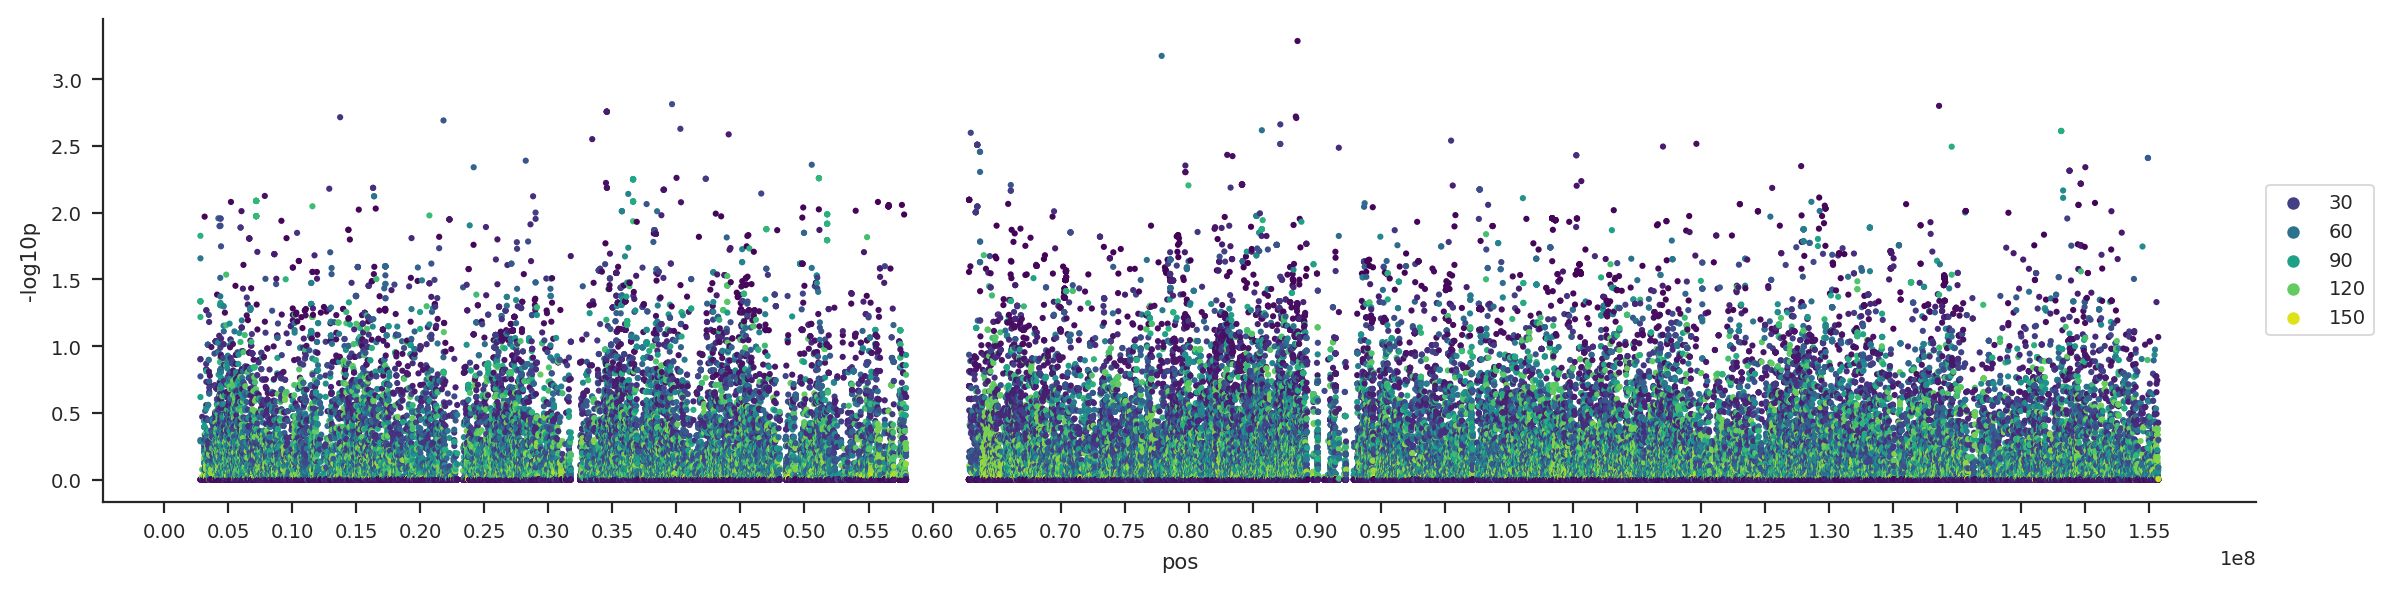

In [20]:
# GWD
plot_GWD = GWD.loc[(GWD.stat_name == 'nr_runs') & (GWD.nr_mut > 20)]
plot_GWD['-log10p'] = -np.log10(plot_GWD.p)
np.log10(plot_GWD.index.size)

import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    fig, ax = plt.subplots(1, 1, figsize=(12,3))
    sns.scatterplot(data=plot_GWD, x='pos', y='-log10p', hue='stat', palette='viridis', ax=ax, linewidth=0, s=5) ;
    ax.set_xticks(np.arange(0, max(GWD.pos)+1, 5000000))
    # ax.axhline(-np.log10(0.001), color='red', linestyle='dashed') ;
    # ax.get_legend().remove()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    sns.despine()

In [3]:
import pandas as pd

# Assuming LWK DataFrame is already loaded as shown in your example
LWK = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_LWK_runstats.h5')

# Select the columns 'pos' and 'p'
LWK_selected = LWK[['pos', 'p']]

# Save the selected columns to a new CSV file
LWK_selected.to_csv('/home/ari/ari-intern/people/ari/ariadna-intern/results/selected_columns.csv', index=False)
